# Closed Loop Mass Spectrometry - Simple Example

The following notebook provides a simplified example related to closed loop mass spectrometry experiements. In these experiments we observe metabolites across multiple sample. The locations of the metabolites remain similar but are subject to a systematic change in the time that they occur. This example shows how it is possible to estimate this time drift and match the metabolites across samples. 

## 1. Load some packages

In [1]:
import numpy as np
import copy

In [2]:
import pylab as plt
%matplotlib inline

In [3]:
import sys
sys.path.append('../..')

In [4]:
from CLGP import *

In [5]:
%load_ext autoreload
%autoreload 2

## 2. Create Data

- In an initial experiment we have measured a set of objects (metabolites), each of which is characterised by time. For some of these objects we also have some information to uniquely identify them.
- In a second experiment we then measure another set of objects, some of which will be the same as objects in the first experiment and some will not
- For those objects that match between the experiments, there will be a time drift with respect to the time they were observed in the first experiment
- Our goal is to match the objects which are the same via inferring the time drift between experiments
- We can learn the drift using points that we can match (based upon the additional information described above). But there is a cost associated with these additional measurements and we can make only a limited number of them
- When we make such a measurement it will tell us that either:
    - the point we measure is the same as one of the ones in set 1 for which the additional information is available, or...
    - it is not the same as any for which additional information is available
    
Note: in reality, the problem is more constrained as we have to make the additional measurements in time order...

### 2.1. Create Initial Dataset

In total we have `N` objects across our two samples. In total each sample contains `n_data` of the `N` objects, meaning that there is overlap between the two samples

In [6]:
N = 30 # total number of objects which could be in either dataset
n_data = 25 # total number of objects in a dataset
true_vals, data_1_idx, data_2_idx = create_dataset(N, n_data)

Size of Overlap between datasets = 21


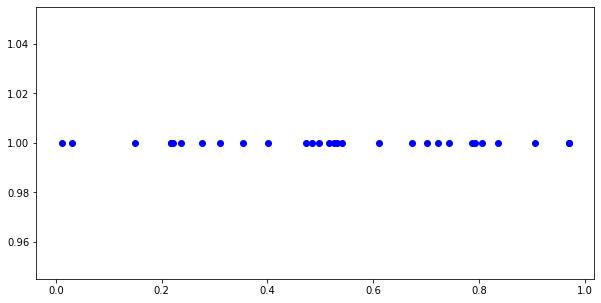

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(true_vals, [1 for i in range(len(true_vals))], 'bo')
plt.show()

During the first experiment, some of the objects in the first sample had additional information collected about them. This information uniquely identifies the object and allows it to be matched to the same object in the second sample, even if the times are significantly different. We cannot confirm the identity of any object without this additional information, and therefore cannot match it to the second sample.

In [8]:
frag_prob_1 = 0.7
frag_1 = add_frag_events(n_data, frag_prob_1)

We can plot the time that the objects are observed in the first sample (x-axis) against their index (y-axis). Here we see that some objects have additional information and some do not. Note, we do not use the index (y-axis) to match the objects, it just helps with plotting.

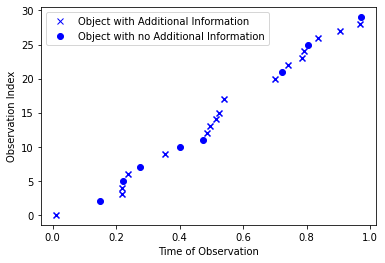

In [9]:
plot_frag_dataset(true_vals, data_1_idx, frag_1)

### 2.2. Create Drift Function

Next we sample the time drift for the objects in the second dataset using a Gaussian Process (GP)

In [10]:
alpha = 0.01
gam = 1.
K, true_offset_function = create_drift(true_vals, alpha, gam)

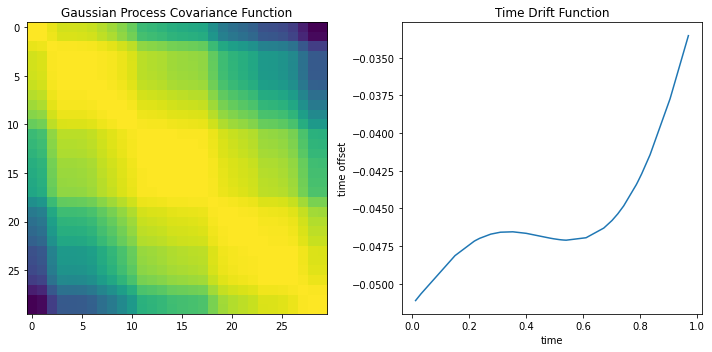

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # label this
ax = axes[0]
ax.set_title('Gaussian Process Covariance Function')
plot = ax.imshow(K,aspect='auto')
plt.plot(true_vals,true_offset_function)
plt.title('Time Drift Function')
plt.xlabel('time')
plt.ylabel('time offset')
fig.tight_layout()
plt.show()

### 2.3. Create Observed Datasets

Using the generated time drift from the GP, we can now generate the observed times for the second sample. Dataset 1 (black dots) takes the original times we generated, with the dataset 2 (green dots) taking those times plsu the time drift and some random noise.

In [12]:
noise_ss = 0.00000
observed_1, observed_2, main_K = create_observed_datasets(true_vals, data_1_idx, data_2_idx, true_offset_function, noise_ss, alpha, gam)

We can now plot the data, where true matches are shown as horizontal lines (any non-horizontal line would be an incorrect match). Note that some objects do not have matches as they only appear in one of the two datasets.

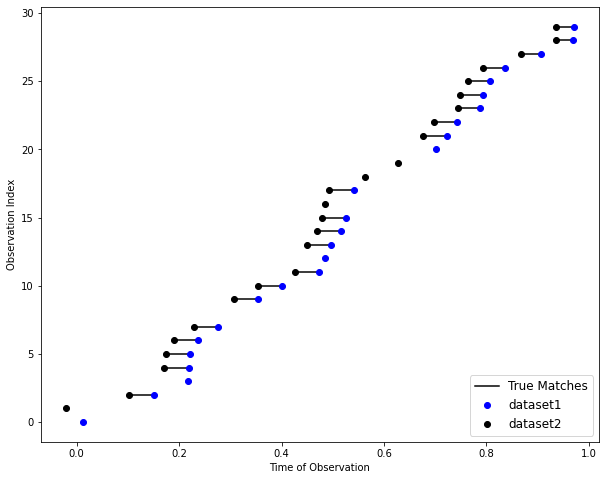

In [13]:
plot_datasets(observed_1, observed_2, data_1_idx, data_2_idx, true_matching=True, figsize=(10,8))

# 3. Example Process

__Plots__
- left plot - The current drift values for each matched against the time of the object from dataset2. The drift and estimated drift are also show
- right plot - the observation times of the objects for each datasets against their index. Currently matched objects are show along with whether that match is confirmed, unconfirmed or incorrect.

__Process__
The following is a walk through of a single iteration of the update process

We start with an initial matching based on a zero mean Gaussian Process prior (blue line - predicted drift) which assumes that there is no time drift between samples, i.e. pairs are matched based on their unadjusted observed times. Currently there is additional information for some observations in dataset1, but none in dataset2. There are therefore no confirmed matches.


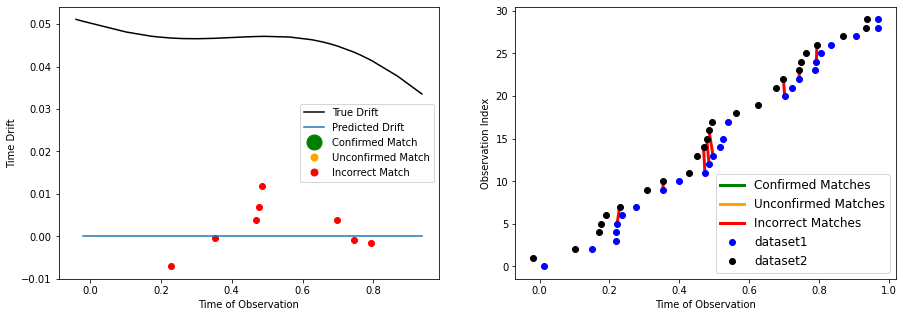

We pick a observation to query in dataset2 (highlighted in green on right-hand side). This query gives us the information needed to potentially match that observation to one observed in dataset1.


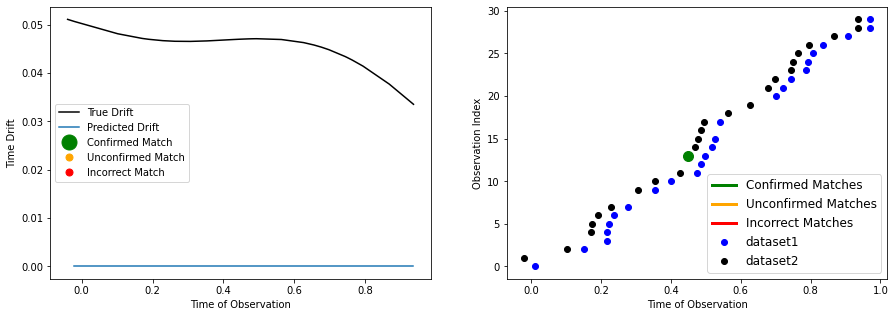

We then look for a match in dataset1 based on the new additional information. If there is a match, then we match these points together and add the matched pair to the training data for the Gaussian Process drift model.


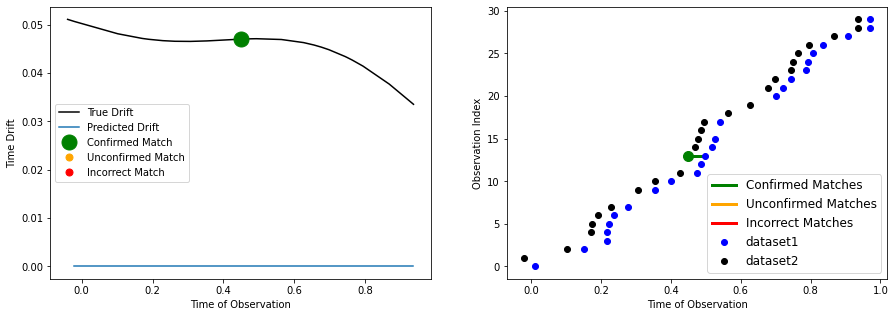

Based on the updated training data (green point on left-hand side), we refit the Gaussian Process.


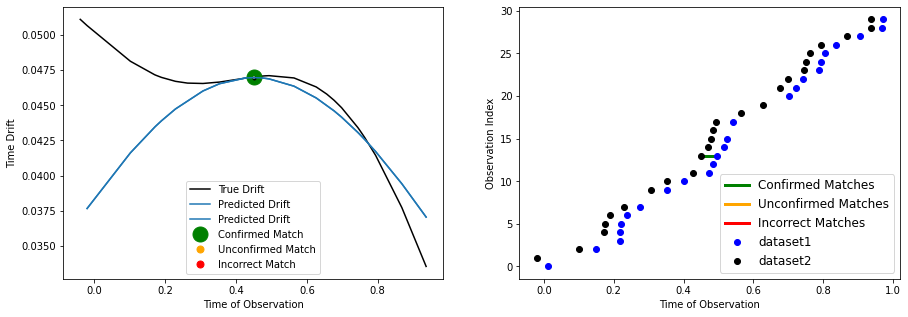

Using the updated Gaussian Process to account for the time drift, we then update the matchings.


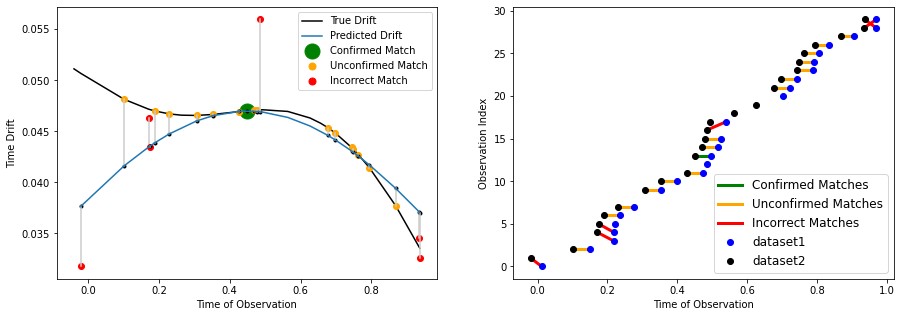

We would then pick another unqueried point from dataset2 and repeat the process multiple times.


In [14]:
max_rt = 0.02
ExampleExperiment(observed_1, observed_2, data_1_idx, data_2_idx, frag_1, main_K, max_rt,true_vals,true_offset_function).run()

### 4. Full Example

The following a run through of an example process run for a few iterations

__Plots__

- left plot - The current drift values for each matched against the time of the object from dataset2. The drift and estimated drift are also show
- right plot - the observation times of the objects for each datasets against their index. Currently matched objects are show along with whether that match is confirmed, unconfirmed or incorrect.|

Initial matches based on no time drift and picking the closest matches.
For the figure below, there is a total of 8 matches, of which there are 0 correct and 8 incorrect.


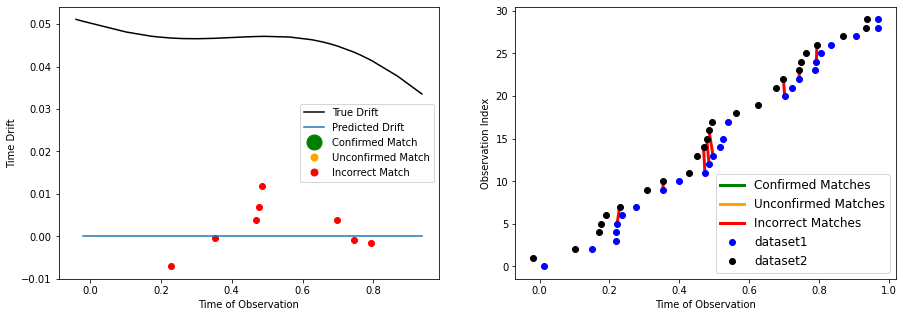

The next query resulted in a new confirmed match. The GP has been refitted and the matching updated.
For the figure below, there are now a total of 22 matches, of which there are 1 confirmed, 13 unconfirmed and 8 incorrect.


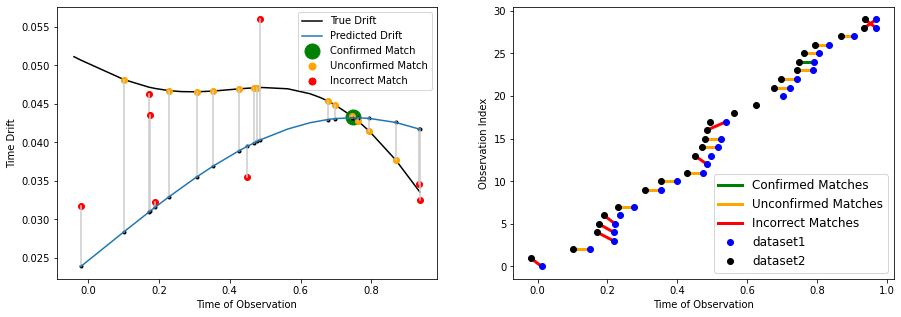

The next query did not match anything previously observed.
For the figure below, there are now a total of 22 matches, of which there are 1 confirmed, 13 unconfirmed and 8 incorrect.


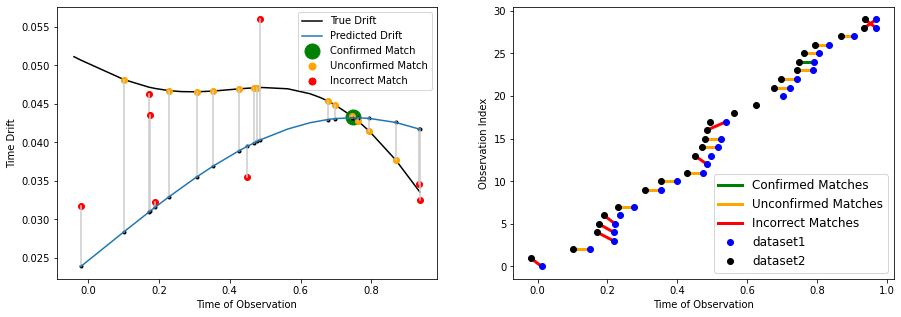

The next query did not match anything previously observed.
For the figure below, there are now a total of 22 matches, of which there are 1 confirmed, 13 unconfirmed and 8 incorrect.


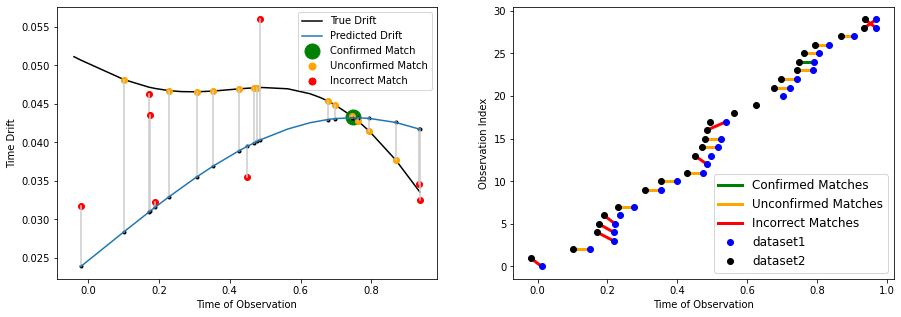

The next query resulted in a new confirmed match. The GP has been refitted and the matching updated.
For the figure below, there are now a total of 22 matches, of which there are 2 confirmed, 16 unconfirmed and 4 incorrect.


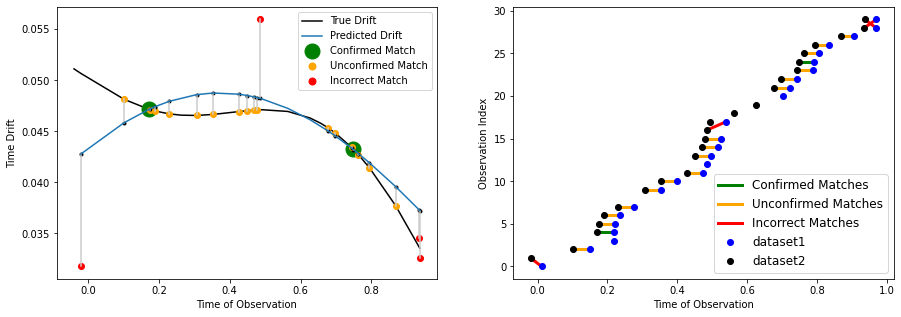

The next query did not match anything previously observed.
For the figure below, there are now a total of 22 matches, of which there are 2 confirmed, 16 unconfirmed and 4 incorrect.


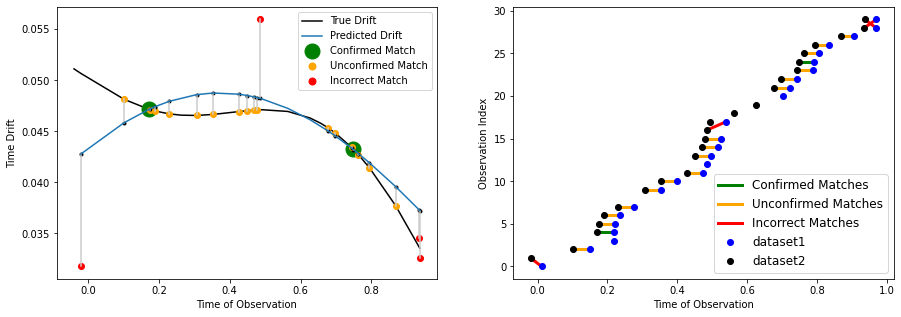

The next query did not match anything previously observed.
For the figure below, there are now a total of 22 matches, of which there are 2 confirmed, 16 unconfirmed and 4 incorrect.


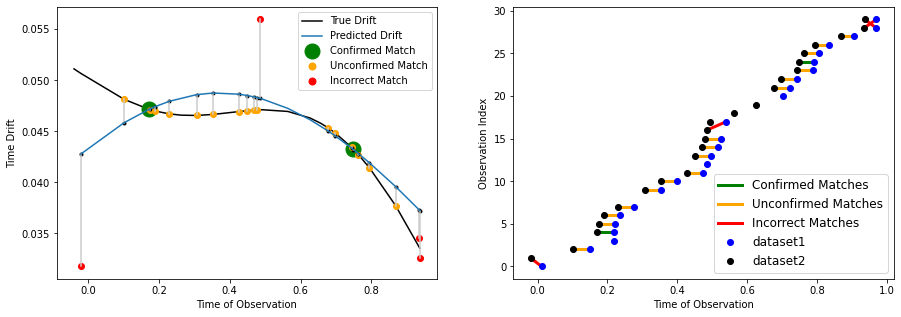

The next query did not match anything previously observed.
For the figure below, there are now a total of 22 matches, of which there are 2 confirmed, 16 unconfirmed and 4 incorrect.


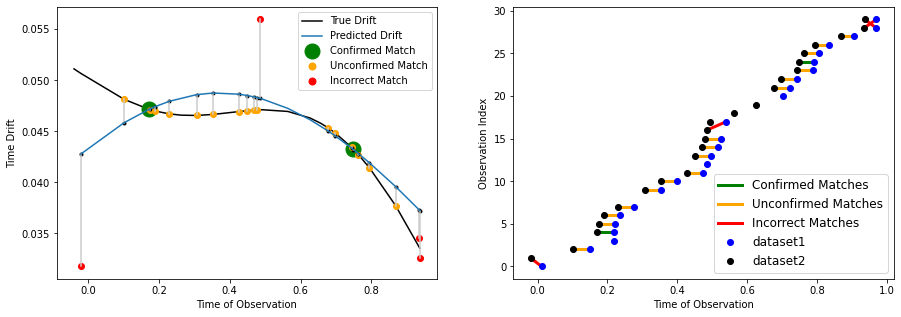

The next query did not match anything previously observed.
For the figure below, there are now a total of 22 matches, of which there are 2 confirmed, 16 unconfirmed and 4 incorrect.


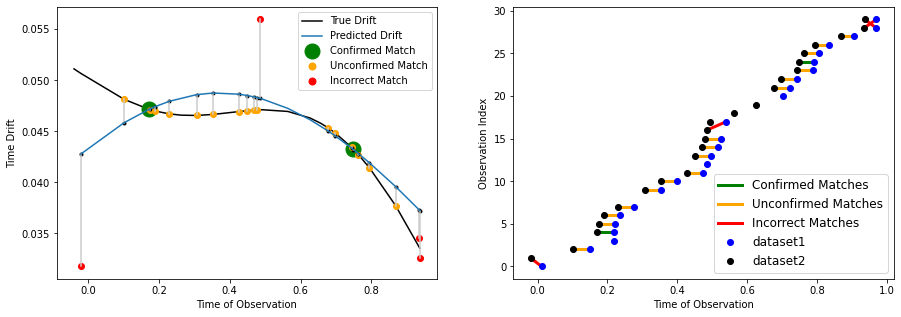

The next query did not match anything previously observed.
For the figure below, there are now a total of 22 matches, of which there are 2 confirmed, 16 unconfirmed and 4 incorrect.


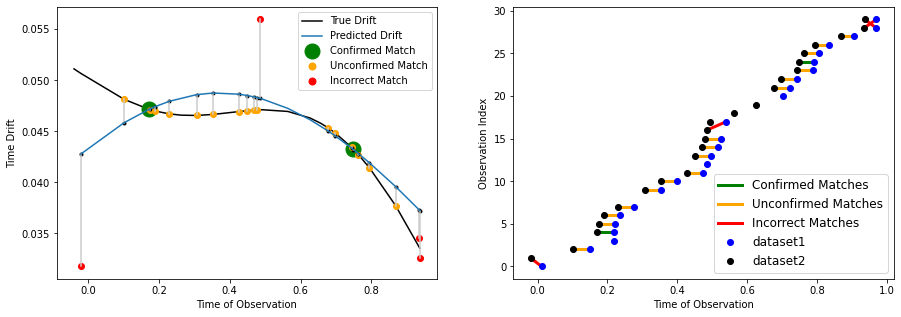

The next query resulted in a new confirmed match. The GP has been refitted and the matching updated.
For the figure below, there are now a total of 22 matches, of which there are 3 confirmed, 17 unconfirmed and 2 incorrect.


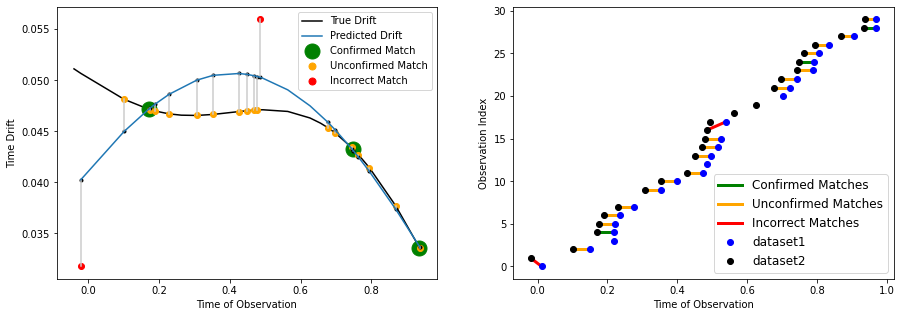

In [27]:
n_its = 10
max_rt = 0.02
match_method = None
SimpleExperiment(n_its,observed_1, observed_2, data_1_idx, data_2_idx, frag_1, main_K, match_method, max_rt,true_vals,true_offset_function).run()

### 5. General Closed Loop Challenges

There are a number of closed loop issues within the CLMS simple example and main problem. These are described in more detail below.

__Time based budget__

The CLMS problem has a time-based budget. In the simple example we are limited to a maximum number of queries (iterations), while in the main problem we have a limited number of scans and are also limited as to when we can do certain scans. Allocating these queries / scans in real time and in an effective manner is difficult and can result in trade-offs which can have unexpected closed loop consequences.

__Noise in Additional Information__

In the simple example we assume that the queries give us information that will also us to match pairs with 100% certainty if we have the necessary information. In reality the quality of this information can vary, and we therefore potentially have to use information that is noisy and not perfect. What level of accuracy we choose to require in order to match things will have a significant effect on our results and future decisions. Requiring only low accuracy will lead to lots of incorrect matches and lead to a misestimation of the drift function. Requiring very high accuracy will lead to only a few matches, not enough information to accurately estimate the drift function and a strong bias to the prior settings.

__Making Decisions on Partially Observed Data__

In the simple example we fully observe both datasets before making any decision, this is not the case with the main problem. In the main problem we observe peaks which are observed over a period of time rather than single observation (equivalent to the top of a peak). Any decision to scan a peak must be made based on only a partially observed peak, as scanning a peak after it has disappeared would provide no actionable information. Making a bad prediction and therefore a bad decision could lead to a number of unintended consequences: missing interesting events, mis-matching peaks leading to mis-estimating the drift function, or wasting scans on something non interesting.

__Feedback Consequences of Predicting the Drift Function__

In the main problem there are going to be several sources of error going into the data used to estimate the drift function: noise in additional information and decisions made on partially observed data. This error will propagate into the estimation of the drift function which will in turn effect the future decisions we make. Understanding and accounting for these errors is vital for reducing the closed loop effects from estimating this real time drift function.

__Experiment Bias__

Choosing where we query / scan can lead to unintended bias in the final analyses. If we choose to not query / scan objects due to what we think we know about it already, then we can end up missing something which we would not have otherwise. This can affect the final analyses and the conclusions that we make from it.

__Exploitation versus Exploration__

As the quality of the additional information we get from queries / scans is not always good, it is sometimes necessary to re-query/scan an object. This means we have an exploitation versus exploration problem where we must weigh up the relative merits of re-querying something we have already queried, or querying something new that we are interested in.

__Competing Objectives__

There are several competing objectives within the main problem that must be accounted for when choosing where to query / scan. Firstly, we have to choose between exploitation and exploration, secondly we have to choose between those objectives and doing scans that would help us to estimate our drift function. Improving the estimation of the drift function will help us with future choices, but is it worth it if we have to trade it for an interesting exploitation or exploration query /scan?